In [2]:
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
import csv
import multiprocessing as multiprocessing
from Bio import SeqIO
from Bio import AlignIO
import os
import re
from scipy import stats
from Bio import pairwise2
from Bio.pairwise2 import format_alignment 
from Bio.Seq import Seq 
from multiprocessing import Pool
from FunctionsAnalyzeNanopore import ProcessFile
from FunctionsAnalyzeNanopore import ConcatenateDataFrame
from FunctionsAnalyzeNanopore import CalculateMismatchIndels
from FunctionsAnalyzeNanopore import CountSelectedMismatches
from FunctionsAnalyzeNanopore import CountAllMismatches

sns.set_style("whitegrid")

num_cores = multiprocessing.cpu_count()
# num_cores = 6
pool_obj = multiprocessing.Pool()

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
#SET EXPERIMENT TO ANALYZE. save this in some file eventually

GFPseqF = "tgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaa"
eveMSEF = "GCAGCACGAGGTGGCAGTGGCCAGATACTGCGACCTCCCTAGCAAACTGGGGCACAAGCTTAATTGAtctagagcatgTAATACGACTCACTATAGCATGTAATACGACTCACTATAGCATGcaggttacccggtactgcataacaatggaacccgaaccgtaactgggacagatcgaaaagctggcctggtttctcgctgtgtgtgccgtgttaatccgtttgccatcagcgagattattagtcaattgcagttgcagcgtttcgctttcgtcctcgtttcactttcgagttagactttattgcagcatcttgaacaatcgtcgcagtttggtaacacgctgtgccatactttcatttagacggaatcgagggaccctggactataatcgcacaacgagaccgggttgcgaagtcagggcattccgccgatctagccatcgccatcttctgcgggcgtttgtttgtttgtttgctgggattagccaagggcttgacttggaatccaatcccgatccctagcccgatcccaatcccaatcccaatcccttgtccttttcattagaaagtcataaaaacacataataatgatgtcgaagggattaggggcgaattcggccggccgcttcgagc"
Sequence = GFPseqF.upper()
#GFPseqF = GFPseqF.upper()
#GFPseqR = str(Seq(GFPseqF).reverse_complement())

IsDuplex = 0
Path = '/Volumes/Elements/Illumina/20240326_MEJFS010/' ; gRNAFile = 'gRNAs_empty.csv' ; CutStart = 120 ; CutEnd = 20
LongPath = Path+'AID-T7RNAPol_eve2_S2_embryos/'

Path = '/Volumes/Elements/Illumina/20240516_MEYDT011/' ; gRNAFile = 'gRNAs_4.csv' ; CutStart = 15 ; CutEnd = 75
LongPath = Path+'AID-evoCDA_GFP/'


# import barcodes for multiplexing
MPxFile = Path + 'multiplexing.csv'
gRNAFile = Path + gRNAFile

Dir =  Path + 'merged/'
os.makedirs(Dir,exist_ok = True)

DirOut =  Path + 'plots-sup/'

os.makedirs(DirOut,exist_ok = True)

P7seq = ''
R2seq = ''
P5seq = ''
R1seq = ''
Index = ''
PrimerFWD = P5seq + '' + R1seq
PrimerREV = P7seq + Index + R2seq




In [4]:
DictTranslate = str.maketrans({"N": "0","A": "1","C": "2","T": "3","G": "4","-": "5","I": None})
DictTranslateREV = str.maketrans({ "0":"N", "1":"A", "2":"C", "3":"T", "4":"G", "5":"-"})
DictComp = str.maketrans({"N": "N","A": "T","C": "G","T": "A","G": "C","-": "-","I": "I"})

# GFPseqF = PrimerFWD+GFPseqF.upper()+str(Seq(PrimerREV).reverse_complement())
# GFPseqR = str(Seq(GFPseqF).reverse_complement())
GFPseqF = Sequence
GFPseqR = str(Seq(Sequence).reverse_complement())
LibraryLength = len(GFPseqF)
#print(GFPseqF)

DictMultiplexing = {}
ControlSamples = []
index = 0
with open(MPxFile, newline='') as csvfile:
    reader = csv.reader(csvfile, dialect='excel')
    for row in reader:
        Sample = row[0]
        Index = row[1]
        Description = row[2]
        Experiment = row[3]
        try:
            Genotype = row[4]
            Type = row[5]
            Time = row[6]
        except:
            Genotype = 'NaN'
            Type = 'NaN'
            Time = 0
        DictMultiplexing[Sample] = {'Sample':Sample,'Index':Index,'Description':Description,'Experiment':Experiment,'Genotype':Genotype,'Type':Type,'Time':Time}
        if Type == 'control' or Type == 'ctr':
            ControlSamples.append(index)
        index += 1     
ExperimentSamples = range(0,len(DictMultiplexing))

print(ExperimentSamples)
print(ControlSamples)


range(0, 12)
[0, 4]


In [ ]:
Files = []
for k in DictMultiplexing.keys():
    fastapath = DictMultiplexing[k]['Description']+'/'+DictMultiplexing[k]['Experiment']
    FilesTemp = [DictMultiplexing[k]['Description']+'/'+f for f in os.listdir(LongPath+DictMultiplexing[k]['Description']) if re.match(r"\w.*\.fastq\.gz$", f)]
    Split = FilesTemp[0].split('_001.fastq.gz')
    File = Split[0][0:-2]
    os.system("/usr/local/bin/bbmap/bbmerge.sh in1="+LongPath+File+"R1_001.fastq.gz in2="+LongPath+File+"R2_001.fastq.gz out="+Dir+DictMultiplexing[k]['Genotype']+"_merged.fastq.gz outu1="+Dir+DictMultiplexing[k]['Genotype']+"_R1_unmerged.fastq.gz outu2="+Dir+DictMultiplexing[k]['Genotype']+"_R2_unmerged.fastq.gz minoverlap=4 extend2=10 iterations=10 ihist="+Dir+DictMultiplexing[k]['Genotype']+"ihist.txt > "+Dir+DictMultiplexing[k]['Genotype']+"_dump_bbmerge.txt")
    #seqkit split2 dorado_sup_duplex.fastq -O ./ -f -s 2000 -e .gz
    print(File)

#print("\n".join(Files[:]))

In [4]:
Files = [f for f in os.listdir(Dir) if re.match(r"\w.*_merged\.fastq\.gz$", f)]
print("\n".join(Files))

control_act5C-5_only_2w_4_merged.fastq.gz
act5C-5_GFPx24gRNAs_2w_31_merged.fastq.gz
act5C-7_GFPx24gRNAs_2w_33_merged.fastq.gz
act5C-evoD_GFPx24gRNAs_2w_36_merged.fastq.gz
ctr_F1_adults_GFPx4gRNAs_merged.fastq.gz
act5C-AID162_GFPx4gRNAs_F2_embryos_merged.fastq.gz
act5C-AID162_GFPx4gRNAs_F2_adults_from_females_merged.fastq.gz
act5C-AID162_GFPx4gRNAs_F2_adults_from_males_merged.fastq.gz
pBam-AID162-1_GFPx4gRNAs_F2_embryos_merged.fastq.gz
pBam-AID162-1_GFPx4gRNAs_F2_adults_from_females_merged.fastq.gz
pBam-AID162-1_GFPx4gRNAs_F2_adults_from_males_merged.fastq.gz


In [5]:
#RUN QUALITY THRESHOLDING, ALIGNMENT AND INDEX MATCHING

FilesSelected = Files # SELECT FILES TO RUN
#delete files that have already been run. comment to overwrite
FilesDF = [f for f in os.listdir(DirOut) if re.match(r"\w.*DF\.csv$", f)]
FilesSelectedCopy = FilesSelected.copy()
for f in FilesSelected:
    if f+'_DF.csv' in FilesDF:
         FilesSelectedCopy.remove(f)
FilesSelected = FilesSelectedCopy.copy()     
print(len(FilesSelected))
print(FilesSelected)

Dictionaries = [DictTranslate,DictTranslateREV,DictComp,DictMultiplexing]
MaxLength = 700
QualityThres = 30 #min average quality to keep read
AlignmentThres = 300 #alignment score threshold #600 for GFP, 1100 for eve
Parameters = [MaxLength,LibraryLength,QualityThres,AlignmentThres,PrimerFWD,PrimerREV]
AlignmentParameters = [2,0,-3,0] #match, mismatch, gap opening, gap extension
IndexPositions = [0,0] #positions where indexes for multiplexing should be


args = [(file,GFPseqF,Dir,DirOut,Dictionaries,Parameters,AlignmentParameters,IndexPositions) for file in FilesSelected]
pool_obj.starmap(ProcessFile,args)


11
['control_act5C-5_only_2w_4_merged.fastq.gz', 'act5C-5_GFPx24gRNAs_2w_31_merged.fastq.gz', 'act5C-7_GFPx24gRNAs_2w_33_merged.fastq.gz', 'act5C-evoD_GFPx24gRNAs_2w_36_merged.fastq.gz', 'ctr_F1_adults_GFPx4gRNAs_merged.fastq.gz', 'act5C-AID162_GFPx4gRNAs_F2_embryos_merged.fastq.gz', 'act5C-AID162_GFPx4gRNAs_F2_adults_from_females_merged.fastq.gz', 'act5C-AID162_GFPx4gRNAs_F2_adults_from_males_merged.fastq.gz', 'pBam-AID162-1_GFPx4gRNAs_F2_embryos_merged.fastq.gz', 'pBam-AID162-1_GFPx4gRNAs_F2_adults_from_females_merged.fastq.gz', 'pBam-AID162-1_GFPx4gRNAs_F2_adults_from_males_merged.fastq.gz']


[None, None, None, None, None, None, None, None, None, None, None]

In [1]:
# COMBINE ALL CSV FILES TOGETHER
# needs to have fun second cell to get DirOut

FilesDF = [f for f in os.listdir(DirOut) if re.match(r"^\w.*DF\.csv$", f)]
FilesIn = [f for f in os.listdir(DirOut) if re.match(r"^\w.*DFInsertions\.csv$", f)]
FilesDF = sorted(FilesDF)
FilesIn = sorted(FilesIn)
# PropFiles = round(len(Files)*0.002)
# FilesDF = FilesDF[0:PropFiles]
# FilesIn = FilesIn[0:PropFiles]

num_cores = multiprocessing.cpu_count()
pool_obj = multiprocessing.Pool()
args = [(FileSet,DirOut) for FileSet in [FilesDF,FilesIn]]
[DFall,DFInall] = pool_obj.starmap(ConcatenateDataFrame,args)


DFall['Sample'] = DFall['Sample'].astype(str)
DFInall['Sample'] = DFInall['Sample'].astype(str)

DFall = DFall.sort_values('Sample', ascending=True, key=lambda col: col.str.lower())
DFInall = DFInall.sort_values('Sample', ascending=True, key=lambda col: col.str.lower())

Experiments = DFInall['Sample'].unique()
Descriptions = DFInall['Sample'].unique()
i=0
for sample in DFInall['Sample'].unique():
    try:
        Experiments[i] = DictMultiplexing[sample]['Experiment']
        Descriptions[i] = DictMultiplexing[sample]['Description']
    except:
        print(sample+' not found')
    i+=1

NameError: name 'os' is not defined

In [7]:
# CALCULATE MISMATCHES TO REF AND INDELS
num_cores = 4
pool_obj = multiprocessing.Pool()

MatrixMM = np.zeros((len(DFall['Sample'].unique()),LibraryLength),float)
MatrixIndels = np.zeros((len(DFall['Sample'].unique()),LibraryLength),float)
MatrixAllDiff = np.zeros((len(DFall['Sample'].unique()),LibraryLength),float)
Ns = 0*len(DFall['Sample'].unique())
REF = DFall[DFall['Sample'] == 'REF']
REFgRNAs = REF.copy()
REFgRNAsFWD = REF.copy()*0
REFgRNAsREV = REF.copy()*0
REFgRNAsCutSites = REF.copy()*0

gRNAsDF = pd.read_csv(gRNAFile, sep = ',')
for index, row in gRNAsDF.iterrows():
    Start = row['Start']+len(PrimerFWD)
    End = row['End']+len(PrimerFWD)
    Orientation = row['Orientation']
    REFgRNAs.iloc[:,Start-1:End] = 0
    if Orientation == '+':
        REFgRNAsFWD.iloc[:,Start-1:End] = 1
        REFgRNAsCutSites.iloc[:,End-3] = 1
    else:
        REFgRNAsREV.iloc[:,Start-1:End] = 1
        REFgRNAsCutSites.iloc[:,Start+2] = 1

DFall[DFall['Sample'] == 'REF'] = REFgRNAs
args = [(DFall,DFInall,sample,LibraryLength,REF) for sample in DFall['Sample'].unique()]
[Mismatch, Indels, AllDiff,DFMutations, N, Samples] = zip(*pool_obj.starmap(CalculateMismatchIndels,args))
print('done')


done


In [8]:
#only when everything was run with the wrong order, create new multiplexing with reordered sample numbers
try:
    MPxFile2 = Path + 'multiplexing-reordered.csv'
    DictMultiplexing2 = {}
    ControlSamples2 = []
    NewOrder = []
    index = 0
    with open(MPxFile2, newline='') as csvfile:
        reader = csv.reader(csvfile, dialect='excel')
        for row in reader:
            Sample = row[0]
            Index = row[1]
            Description = row[2]
            Experiment = row[3]
            try:
#                 Genotype = row[4]
                Type = row[5]
                Time = row[6]
            except:
                Genotype = 'NaN'
                Type = 'NaN'
                Time = 0
            DictMultiplexing2[Sample] = {'Sample':Sample,'Index':Index,'Description':Description,'Experiment':Experiment,'Genotype':Genotype,'Type':Type,'Time':Time}
            NewOrder.append(int(Sample))
            if Type == 'control' or Type == 'ctr':
                ControlSamples2.append(int(Sample)-1)
            index += 1 
    NewOrder.append(max(NewOrder)+1)
    NewOrder.append(max(NewOrder)+1)
    ExperimentSamples2 = range(0,len(DictMultiplexing2))
    print(ExperimentSamples2)
    print(ControlSamples2)
    print(NewOrder)
    Mismatch_temp = [0]*len(N)
    DFMutations_temp = [0]*len(N)
    Indels_temp =[0]*len(N)
    N_temp = [0]*len(N)
    Samples_temp = [0]*len(N)
    Descriptions_temp = [0]*len(N)
    count = 0
    for i in NewOrder:
        Mismatch_temp[i-1] = Mismatch[count]
        DFMutations_temp[i-1] = DFMutations[count]
        Indels_temp[i-1] = Indels[count]
        N_temp[i-1] = N[count]
        Samples_temp[i-1] = Samples[count]
        Descriptions_temp[i-1] = Descriptions[count]
        count += 1
    print(Samples_temp)
    Mismatch = Mismatch_temp
    DFMutations = DFMutations_temp
    Indels = Indels_temp
    N = N_temp
    Samples = Samples_temp
    Descriptions = Descriptions_temp
    ControlSamples = ControlSamples2
    ExperimentSamples = ExperimentSamples2
    print(Samples)
except:
    print('no update needed')


no update needed


In [23]:
# PLOT PROFILES MISMATCH/INDELS AND HEATMAPS AVERAGE SAMPLES

Threshold = 100
samplei = 0
fig1, axes1 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=True, sharey=True, figsize=(20,10))
fig2, axes2 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=True, sharey=True, figsize=(20,10))
for sample in DFall['Sample'].unique():
    MM = Mismatch[samplei] 
    ID = Indels[samplei]
    Neach = N[samplei]
    plot = sns.lineplot(ax=axes1[math.ceil((samplei+1)/6)-1,samplei-((math.ceil((samplei+1)/6))-1)*6],x=range(0,len(MM)),y=MM*100)
    plot.set(title=Samples[samplei]+' n='+str(Neach)+'\n'+Descriptions[samplei],ylim=(0, Threshold),ylabel = '% mismatched', xlabel = 'position (bp)')
    plot = sns.lineplot(ax=axes2[math.ceil((samplei+1)/6)-1,samplei-((math.ceil((samplei+1)/6))-1)*6],x=range(0,len(ID)),y=ID*100)
    plot.set(title=Samples[samplei]+' n='+str(Neach)+'\n'+Descriptions[samplei],ylim=(0, Threshold),ylabel = '% indel', xlabel = 'position (bp)')
    MatrixMM[samplei,:] = MM
    MatrixIndels[samplei,:] = ID
    MatrixAllDiff[samplei,:] = AllDiff[samplei]
    samplei += 1
fig1.suptitle('% mismatched reads to GFP in each position from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
fig1.tight_layout()
fig1.savefig(DirOut+"allcombined_mismatched_samples_"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
fig1.clf()
plt.close()
fig2.suptitle('% indels in each position from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
fig2.tight_layout()
fig2.savefig(DirOut+"allcombined_indels_samples_"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
fig2.clf()
plt.close()

np.savetxt(DirOut+"allcombined_MatrixMM."+str(len(FilesIn))+"-"+str(len(Files))+"files.csv", MatrixMM, delimiter=",")
np.savetxt(DirOut+"allcombined_MatrixIndels."+str(len(FilesIn))+"-"+str(len(Files))+"files.csv", MatrixIndels, delimiter=",")
np.savetxt(DirOut+"allcombined_Ns."+str(len(FilesIn))+"-"+str(len(Files))+"files.csv",N,delimiter=",")


Experiments = pd.DataFrame(Experiments)
lut = dict(zip(set(Experiments[0]), sns.color_palette("viridis",len(Experiments[0]))))
row_colors = Experiments[0].map(lut).to_numpy()

hmM = sns.clustermap(MatrixMM*100,col_cluster=False,row_cluster=False,figsize=(10, 10),vmin=0,vmax = Threshold, yticklabels=Descriptions, row_colors = row_colors, cbar_kws={'label': '% mismatch'})
for Control in ControlSamples:
    hmM.ax_heatmap.axhline(Control, color='white', lw=2)
hmM.ax_heatmap.text(-15, 6,Experiments[0][0],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 15,Experiments[0][8],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 25,Experiments[0][20],rotation=90,color='w')
hmM.ax_heatmap.text(-15, 28.5,'R',rotation=90,color='w')
hmM.ax_heatmap.text(-15, 29.5,'U',rotation=90,color='w')
hmM.ax_heatmap.text(163, 28.75,'gRNAs',rotation=0,color='k')
hmM.ax_cbar.set_position((0.075,0.6, .03, .2))
hmM.fig.suptitle('% mismatched reads to GFP in each position from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
hmM.savefig(DirOut+"allcombined_heatmapMismatched"+str(len(FilesIn))+"-"+str(len(Files))+"files.png",dpi=300)
hmM.fig.clf()
plt.close()

hmM = sns.clustermap(MatrixIndels*100,col_cluster=False,row_cluster=False,figsize=(10, 10),vmin=0,vmax = Threshold, yticklabels=Descriptions, row_colors = row_colors, cbar_kws={'label': '% indels'})
for Control in ControlSamples:
    hmM.ax_heatmap.axhline(Control, color='white', lw=2)
hmM.ax_heatmap.text(-15, 6,Experiments[0][0],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 15,Experiments[0][8],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 25,Experiments[0][20],rotation=90,color='w')
hmM.ax_heatmap.text(-15, 28.5,'R',rotation=90,color='w')
hmM.ax_heatmap.text(-15, 29.5,'U',rotation=90,color='w')
hmM.ax_heatmap.text(163, 28.75,'gRNAs',rotation=0,color='k')
hmM.ax_cbar.set_position((0.075,0.6, .03, .2))
hmM.fig.suptitle('% indels in each position from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
hmM.savefig(DirOut+"allcombined_heatmapIndels"+str(len(FilesIn))+"-"+str(len(Files))+"files.png",dpi=300)
hmM.fig.clf()
plt.close()

In [24]:
# SUBTRACT BACKGROUND FROM CONTROLS, REPLOT LINEPLOTS AND HEATMAPS

Threshold = 100

fig1, axes1 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=True, sharey=True, figsize=(20,10))
fig2, axes2 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=True, sharey=True, figsize=(20,10))

# Mismatch_BG = Mismatch.copy()
# Indels_BG = Indels.copy()
MatrixMM_BG = np.zeros((len(DFall['Sample'].unique()),LibraryLength),float)
MatrixIndels_BG = np.zeros((len(DFall['Sample'].unique()),LibraryLength),float)
iREF = Samples.index('REF')
MatrixMM_BG[iREF,:] = MatrixMM[iREF,:]
MatrixIndels_BG[iREF,:] = MatrixMM[iREF,:]


#
#CtrMM = np.sum([a*b for a,b in zip(Mismatch,N)],0)/sum(N)
#CtrID = np.sum([a*b for a,b in zip(Indels,N)],0)/sum(N)

samplei=0
for Exp in ExperimentSamples:
    for Control in ControlSamples:
        if Exp >= Control:
            CtrMM = Mismatch[Control]
            CtrID = Indels[Control]
    MM = Mismatch[Exp] 
    ID = Indels[Exp]
    MatrixMM_BG[Exp,:] = MM-CtrMM
    MatrixIndels_BG[Exp,:] = ID-CtrID
    plot = sns.lineplot(ax=axes1[math.ceil((samplei+1)/6)-1,samplei-((math.ceil((samplei+1)/6))-1)*6],x=range(0,len(MM)),y=(MM-CtrMM)*100)
    plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp],ylim=(0, Threshold),ylabel = '% mismatched', xlabel = 'position (bp)')
    plot = sns.lineplot(ax=axes2[math.ceil((samplei+1)/6)-1,samplei-((math.ceil((samplei+1)/6))-1)*6],x=range(0,len(ID)),y=(ID-CtrID)*100)
    plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp],ylim=(0, Threshold),ylabel = '% indel', xlabel = 'position (bp)')
    samplei+=1

fig1.suptitle('% mismatched reads to GFP in each position after background substraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
fig1.tight_layout()
fig1.savefig(DirOut+"allcombined_mismatched_samples_-background_"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
fig1.clf()
plt.close()
fig2.suptitle('% indels in each position after background substraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
fig2.tight_layout()
fig2.savefig(DirOut+"allcombined_indels_samples_-background_"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
fig2.clf()
plt.close()


# REPLOT HEATMAPS AFTER BACKGROUND SUBTRACTION

Experiments = pd.DataFrame(Experiments)
lut = dict(zip(set(Experiments[0]), sns.color_palette("viridis",len(Experiments[0]))))
row_colors = Experiments[0].map(lut).to_numpy()

hmM = sns.clustermap(MatrixMM_BG[:,len(PrimerFWD):len(GFPseqF)-len(PrimerREV)]*100,col_cluster=False,row_cluster=False,figsize=(10, 10),vmin=0,vmax = Threshold, yticklabels=Descriptions, row_colors = row_colors, cbar_kws={'label': '% mismatch'},rasterized=True,xticklabels=50)
for Control in ControlSamples:
    hmM.ax_heatmap.axhline(Control, color='white', lw=1)
    hmM.ax_heatmap.axhline(Control+1, color='white', lw=1)

hmM.ax_heatmap.text(-15, 6,Experiments[0][0],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 15,Experiments[0][8],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 25,Experiments[0][20],rotation=90,color='w')
hmM.ax_heatmap.text(-15, 28.5,'R',rotation=90,color='w')
hmM.ax_heatmap.text(-15, 29.5,'U',rotation=90,color='w')
hmM.ax_heatmap.text(163, 28.75,'gRNAs',rotation=0,color='k')
hmM.ax_cbar.set_position((0.075,0.6, .03, .2))
hmM.fig.suptitle('% mismatched reads to GFP in each position after background subtraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
hmM.savefig(DirOut+"allcombined_heatmapMismatched_noBG"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf",dpi=600)
hmM.fig.clf()
plt.close()

hmM = sns.clustermap(MatrixIndels_BG[:,len(PrimerFWD):len(GFPseqF)-len(PrimerREV)]*100,col_cluster=False,row_cluster=False,figsize=(10, 10),vmin=0,vmax = Threshold, yticklabels=Descriptions, row_colors = row_colors, cbar_kws={'label': '% indels'},rasterized=True,xticklabels=50)
for Control in ControlSamples:
    hmM.ax_heatmap.axhline(Control, color='white', lw=1)
    hmM.ax_heatmap.axhline(Control+1, color='white', lw=1)
hmM.ax_heatmap.text(-15, 6,Experiments[0][0],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 15,Experiments[0][8],rotation=90,color='w')
#hmM.ax_heatmap.text(-15, 25,Experiments[0][20],rotation=90,color='w')
hmM.ax_heatmap.text(-15, 28.5,'R',rotation=90,color='w')
hmM.ax_heatmap.text(-15, 29.5,'U',rotation=90,color='w')
hmM.ax_heatmap.text(163, 28.75,'gRNAs',rotation=0,color='k')
hmM.ax_cbar.set_position((0.075,0.6, .03, .2))
hmM.fig.suptitle('% indels in each position after background subtraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
hmM.savefig(DirOut+"allcombined_heatmapIndels_noBG"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf",dpi=600)
hmM.fig.clf()
plt.close()


In [38]:
#SELECT MUTATIONS

#Which = Samples.index('E5')
#Which = Samples.index('#15')
#Which = Samples.index('6_4')

gRNAsDF = pd.read_csv(gRNAFile, sep = ',')
# count number of possible mutation on gRNAs
mutation_limit=0
GFPforCounting=GFPseqF.upper()
for index, row in gRNAsDF.iterrows():   
    Start = row['Start']+len(PrimerFWD)
    End = row['End']+len(PrimerFWD)
    Orientation = row['Orientation']
    gRNAseq = GFPforCounting[Start-1:End]
    print(gRNAseq)
    gRNAseqList = list(gRNAseq)
    x=0 
    while x < len(gRNAseqList): 
        if Orientation == '+'and gRNAseqList[x]=="C":
                mutation_limit+=1
                gRNAseqList[x]='*'
        if Orientation == '-' and gRNAseqList[x]=="G":
                mutation_limit+=1
                gRNAseqList[x]='*'
        x=x+1
    GFPforCounting = GFPforCounting.replace(gRNAseq,''.join(gRNAseqList))

isMutable = [i for i, ltr in enumerate(GFPforCounting) if ltr == '*']
MutationsSelected = [0]*len(GFPseqF)
for i in isMutable:
    MutationsSelected[i] = 1
MutationsSelected = np.array(MutationsSelected) > 0
MutationsSelected = np.transpose(MutationsSelected)
# WhichControl = 1
#MutationsSelected2 = (Mismatch[Which] - Mismatch[ControlSamples[0]]) > 0.005


CATGCCCGAAGGCTACGTCC
CAACTACAAGACCCGCGCCG
*G**GAGGTGAAGTTCGAGGGCG
GGTGAACCGCATCGAGCTGAA


In [40]:
# PLOT BAR PLOT W ALL MISMATCHES AND EACH TYPE BEFORE AND AFTER BG SUBSTRACTION. 

# fig1, axes1 = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(60,10))
# fig2, axes2 = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(20,10))
# fig3, axes3 = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(20,10))
# fig4, axes4 = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(20,10))

gRNAsboo = np.where(REFgRNAs.iloc[0,len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd]==0)
gRNAsbooFWD = np.where(REFgRNAsFWD.iloc[0,len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd]==1)
gRNAsbooREV = np.where(REFgRNAsREV.iloc[0,len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd]==1)
gRNAsbooCuts = np.where(REFgRNAsCutSites.iloc[0,len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd]==1)

Size = 500
DFMutations_BG = list(DFMutations).copy()

#EXP1 act5C 1week
# CtrMM1 = np.average([Mismatch[0],Mismatch[1],Mismatch[2],Mismatch[3],Mismatch[5]],0)
# CtrMMeach1 = np.average([DFMutations[0]/N[0],DFMutations[1]/N[1],DFMutations[2]/N[2],DFMutations[3]/N[3],DFMutations[5]/N[5]],0)
# CtrID1 = np.average([Indels[0],Indels[1],Indels[2],Indels[3],Indels[5]],0)
# CtrMM1 = np.sum([a*b for a,b in zip(Mismatch,N)],0)/sum(N)
# CtrID1 = np.sum([a*b for a,b in zip(Indels,N)],0)/sum(N)
# CtrMMeach1 = np.sum([a*b for a,b in zip(DFMutations,N)],0)/sum(N)

# CtrMM1 = Mismatch[0]
# CtrMMeach1 = DFMutations[0]/N[0]
# CtrID1 = Indels[0]

GFPList = list(GFPseqF)[len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd]
for Exp in range(0,len(Samples)):
    for Control in ControlSamples:
        if Exp >= Control:
            CtrMM = Mismatch[Control]
            CtrMMeach = DFMutations[Control]/N[Control]
            CtrID = Indels[Control]
    f, ax = plt.subplots(4,1,figsize = (25,15))
    MM = Mismatch[Exp] 
    DFMutationsEach = DFMutations[Exp]/N[Exp]*100
    DFMutations_BG[Exp] = DFMutations[Exp]/N[Exp]-CtrMMeach

    DFMM = pd.DataFrame((MM)*100)
    DFMM.iloc[len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd,:].plot(ax = ax[0], kind='bar', width = 1)
    ax[0].set(title = Samples[Exp]+' n='+str(N[Exp])+'   '+Descriptions[Exp]+' total mismatches', ylim = [-5,Threshold],xlabel = 'position (bp)', ylabel = '% mismatch')
    ax[0].set_xticklabels(GFPList, rotation = 0)
    ax[0].grid(False)
    ax[0].scatter(gRNAsbooFWD[0],[-3]*len(gRNAsbooFWD[0]), marker='4', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[0].scatter(gRNAsbooREV[0],[-3]*len(gRNAsbooREV[0]), marker='3', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[0].scatter(gRNAsbooCuts[0]-0.5,[-3]*len(gRNAsbooCuts[0]), marker='|', cmap='summer', c = 'red', s=Size, alpha = 1)

    DFMutationsEach.iloc[len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd,:].plot(ax = ax[1], kind='bar', stacked=True, width = 1, color = sns.color_palette("Spectral",12))
    ax[1].set(title = Samples[Exp]+' n='+str(N[Exp])+'   '+Descriptions[Exp]+' total mismatches by type', ylim = [-5,Threshold],xlabel = 'position (bp)', ylabel = '% mismatch')
    ax[1].set_xticklabels(GFPList, rotation = 0)
    ax[1].grid(False)
    ax[1].scatter(gRNAsbooFWD[0],[-3]*len(gRNAsbooFWD[0]), marker='4', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[1].scatter(gRNAsbooREV[0],[-3]*len(gRNAsbooREV[0]), marker='3', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[1].scatter(gRNAsbooCuts[0]-0.5,[-3]*len(gRNAsbooCuts[0]), marker='|', cmap='summer', c = 'red', s=Size, alpha = 1)
    
    DFMM = pd.DataFrame((MM-CtrMM)*100)
    DFMM.iloc[len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd,:].plot(ax = ax[2], kind='bar', width = 1)
    ax[2].set(title = Samples[Exp]+' n='+str(N[Exp])+'   '+Descriptions[Exp]+' total mismatches after background substraction', ylim = [-5,Threshold],xlabel = 'position (bp)', ylabel = '% mismatch')
    ax[2].set_xticklabels(GFPList, rotation = 0)
    ax[2].grid(False)
    ax[2].scatter(gRNAsbooFWD[0],[-3]*len(gRNAsbooFWD[0]), marker='4', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[2].scatter(gRNAsbooREV[0],[-3]*len(gRNAsbooREV[0]), marker='3', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[2].scatter(gRNAsbooCuts[0]-0.5,[-3]*len(gRNAsbooCuts[0]), marker='|', cmap='summer', c = 'red', s=Size, alpha = 1)
    
    DFMutationsEach = (DFMutations[Exp]/N[Exp]-CtrMMeach)*100
    SumMut = np.sum(DFMutationsEach,1)
    AvMut = np.mean(SumMut.iloc[MutationsSelected])
    DFMutationsEach.iloc[len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd,:].plot(ax = ax[3], kind='bar', stacked=True, width = 1, color = sns.color_palette("Spectral",12))
    ax[3].set(title = Samples[Exp]+' n='+str(N[Exp])+'   '+Descriptions[Exp]+' total mismatches by type after background substraction. '+str(round(AvMut))+'% av mut rate', ylim = [-5,Threshold],xlabel = 'position (bp)', ylabel = '% mismatch')
    ax[3].set_xticklabels(GFPList, rotation = 0)
    ax[3].grid(False)
    ax[3].scatter(gRNAsbooFWD[0],[-3]*len(gRNAsbooFWD[0]), marker='4', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[3].scatter(gRNAsbooREV[0],[-3]*len(gRNAsbooREV[0]), marker='3', cmap='summer', c = 'gray', s=Size, alpha = 0.75)
    ax[3].scatter(gRNAsbooCuts[0]-0.5,[-3]*len(gRNAsbooCuts[0]), marker='|', cmap='summer', c = 'red', s=Size, alpha = 1)
    np.savetxt(DirOut+"MismatchesEachType_"+Samples[Exp]+'_'+Descriptions[Exp]+".csv", DFMutationsEach.iloc[len(PrimerFWD)+CutStart:len(GFPseqF)-len(PrimerREV)-CutEnd,:], delimiter=",")
    np.savetxt(DirOut+"MismatchesEachType_cols.csv",GFPList, delimiter=",", fmt="%s")
    np.savetxt(DirOut+"MismatchesEachType_rows.csv",['AC','AT','AG','CA','CT','CG','TA','TC','TG','GA','GC','GT'] , delimiter=",", fmt="%s")

    f.tight_layout()
    f.savefig(DirOut+"allcombined_mismatched_samples_barplot_"+Samples[Exp]+'_'+str(len(FilesIn))+"-"+str(len(Files))+"files.png",dpi=300)
    f.clf()
    plt.close()

In [43]:
# GET NUMBER PER READ

num_cores = multiprocessing.cpu_count()
pool_obj = multiprocessing.Pool()
args = [(Samples,sample,DFall,REF,LibraryLength,MutationsSelected,GFPseqF,PrimerFWD,PrimerREV) for sample in Samples]
[NumberMutations,Neach] = zip(*pool_obj.starmap(CountSelectedMismatches,args))
print('done')

# NumMut1 = NumberMutations[ControlSamples[WhichControl]]
# NumMut2 = np.concatenate((NumberMutations[14:20]),axis = 0)
# NumMut3 = np.concatenate((NumberMutations[24:28]),axis = 0)

done


In [28]:
Control

4

In [51]:
#PLOT HISTOGRAMS # of SELECTED MUTATIONS
#all histograms
fig1, axes1 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=True, sharey=True, figsize=(20,12))
#all histograms sustracting control
fig2, axes2 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=False, sharey=False, figsize=(20,20))
fig3, axes3 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=False, sharey=False, figsize=(20,12))
DiffHistArray = np.zeros([len(Samples)-1,sum(MutationsSelected)+1])

for Exp in range(0,len(Samples)-1):
    for Control in ControlSamples:
        if Exp >= Control:
            #NumberMutationsCtr = NumberMutations[ControlSamples[Control]]
            NumberMutationsCtr = NumberMutations[Control]
    
    plot = sns.histplot(NumberMutations[Exp],stat='percent',discrete=True,binwidth =1,color="blue",alpha=0.5,ax=axes1[math.ceil((Exp+1)/6)-1,Exp-((math.ceil((Exp+1)/6))-1)*6],log_scale=(False, True))
    plot = sns.histplot(NumberMutationsCtr,stat='percent',discrete=True,binwidth =1,color="orange",alpha=0.5,ax=axes1[math.ceil((Exp+1)/6)-1,Exp-((math.ceil((Exp+1)/6))-1)*6],log_scale=(False, True))
    plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp],xlim = (-0.5,sum(MutationsSelected)),ylim=(0.5,100),ylabel = '% reads', xlabel = '# C-T / G-A mutations')
    plot.set_yticks([0.5,1,10,25,50,90])
    plot.set_yticklabels([0.5,1,10,25,50,90],fontsize = 9)

    hist1, _ = np.histogram(NumberMutations[Exp],range=(0,sum(MutationsSelected)), bins = sum(MutationsSelected)+1)
    hist2, _ = np.histogram(NumberMutationsCtr,range=(0,sum(MutationsSelected)), bins = sum(MutationsSelected)+1)
    DiffHist = (hist1/sum(hist1) - hist2/sum(hist2))*100
    DiffHist[DiffHist<0]=0
    DiffHistArray[Exp,:] = DiffHist
    CumDiffHist = np.cumsum(DiffHist)
    TotalMut = np.sum(DiffHist)
    
    #print(CumDiffHist)
    #DiffHist[0] = 100-sum(DiffHist)
    plot = sns.barplot(x = list(range(0,sum(MutationsSelected)+1,1)), y = DiffHist,color="blue",alpha=0.5, ax=axes2[math.ceil((Exp+1)/6)-1,Exp-((math.ceil((Exp+1)/6))-1)*6])
    plot.grid(axis='x')
    #plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp],xlim = (-0.5,sum(MutationsSelected)),ylim=(0,10),yticks = range(0,11,2),xticks = range(0,sum(MutationsSelected),2), ylabel = '% reads', xlabel = '# C-T / G-A mutations - BG')   
    plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp]+' '+str(round(TotalMut))+'% mutated',xlim = (0,sum(MutationsSelected)),ylim=(0,10),yticks = range(0,16,3),xticks = range(0,sum(MutationsSelected),10), ylabel = '% reads', xlabel = '# C-T / G-A mutations - BG')   

    plot = sns.lineplot(x = list(range(0,sum(MutationsSelected)+1,1)), y = CumDiffHist,color="orange",alpha=0.5, ax=axes3[math.ceil((Exp+1)/6)-1,Exp-((math.ceil((Exp+1)/6))-1)*6])
    plot = sns.barplot(x = list(range(0,sum(MutationsSelected)+1,1)), y = DiffHist,color="blue",alpha=1, ax=axes3[math.ceil((Exp+1)/6)-1,Exp-((math.ceil((Exp+1)/6))-1)*6])
    plot.grid(axis='x')
    #plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp],xlim = (-0.5,sum(MutationsSelected)),ylim=(0,10),yticks = range(0,11,2),xticks = range(0,sum(MutationsSelected),2), ylabel = '% reads', xlabel = '# C-T / G-A mutations - BG')   
    plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp]+' '+str(round(TotalMut))+'% mutated',xlim = (0,sum(MutationsSelected)),ylim=(0,100),yticks = range(0,50,10),xticks = range(0,sum(MutationsSelected),10), ylabel = '% reads', xlabel = '# C-T / G-A mutations - BG')   
  
    Exp+=1

np.savetxt(DirOut+"TableHistograms-BG.csv", DiffHistArray, delimiter=",")
# np.savetxt(DirOut+"MismatchesEachType_cols.csv",GFPList, delimiter=",", fmt="%s")
# np.savetxt(DirOut+"MismatchesEachType_rows.csv",['AC','AT','AG','CA','CT','CG','TA','TC','TG','GA','GC','GT'] , delimiter=",", fmt="%s")
    
fig1.suptitle('% C-T and G-A mismatched reads to GFP in gRNAs before background substraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
fig1.tight_layout()
fig1.savefig(DirOut+"allcombined_mutations_histograms"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
fig1.clf()
plt.close()

fig2.suptitle('% C-T and G-A mismatched reads to GFP in gRNAs after background substraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
fig2.tight_layout()
fig2.savefig(DirOut+"allcombined_mutations_histograms_BG"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
fig2.clf()
plt.close()

fig3.suptitle('% C-T and G-A mismatched reads to GFP in gRNAs after background substraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
fig3.tight_layout()
fig3.savefig(DirOut+"allcombined_mutations_histograms_BG_cumulative"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
fig3.clf()
plt.close()


/var/folders/06/3s9rymq14dl6ps79xbr4t6bw0000gp/T/ipykernel_93778/3139030959.py:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  fig1.clf()


In [16]:
# SELECT ALL BG MUTATIONS AND PLOT NUMBER PER READ
# DFall = pd.read_csv(DirOut+"DFall.csv", sep=",")

# args = [(Samples,sample,DFall,REF,LibraryLength,GFPseqF,PrimerFWD,PrimerREV) for sample in Samples]
# [NumberMutationsAll,_] = zip(*pool_obj.starmap(CountAllMismatches,args))
# print('done')

# NumMutAll1 = NumberMutationsAll[0]

In [17]:
#PLOT HISTOGRAMS # of ALL MUTATIONS
# fig1, axes1 = plt.subplots(math.ceil(len(Samples)/6), 6, sharex=True, sharey=True, figsize=(20,10))

# Exp = 0
# for sample in Samples:
#     if Exp in range(0,8):
#         NumberMutationsAllCtr = NumMutAll1
        
#     plot = sns.histplot(NumberMutationsAll[Exp],stat='percent',discrete=True,binwidth =1,color="blue",alpha=0.5,ax=axes1[math.ceil((Exp+1)/6)-1,Exp-((math.ceil((Exp+1)/6))-1)*6],log_scale=(False, True))
#     plot = sns.histplot(NumberMutationsAllCtr,stat='percent',discrete=True,binwidth =1,color="orange",alpha=0.5,ax=axes1[math.ceil((Exp+1)/6)-1,Exp-((math.ceil((Exp+1)/6))-1)*6],log_scale=(False, True))
#     plot.set(title=Samples[Exp]+' n='+str(N[Exp])+'\n'+Descriptions[Exp],xlim = (0,20), ylim=(0.5,100),ylabel = '% reads', xlabel = '# C-T / G-A mutations')
#     plot.set_yticks([0.5,1,10,25,50,90])
#     plot.set_yticklabels([0.5,1,10,25,50,90],fontsize = 9)
#     Exp+=1
    
# fig1.suptitle('% mismatched reads to GFP before background substraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
# fig1.tight_layout()
# fig1.savefig(DirOut+"allBGcombined_mutations_histograms"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
# fig1.clf()
# plt.close()

/var/folders/06/3s9rymq14dl6ps79xbr4t6bw0000gp/T/ipykernel_93778/717258076.py:46: RuntimeWarning: Mean of empty slice
  sns.lineplot(x=range(1,MaxgRNAlength+1,1),y=np.nanmean(MgRNAsMMAlignedStart,0)*100,marker = 'o', ax = ax[0])
/var/folders/06/3s9rymq14dl6ps79xbr4t6bw0000gp/T/ipykernel_93778/717258076.py:47: RuntimeWarning: Mean of empty slice
  sns.lineplot(x=range(-MaxgRNAlength,0,1),y=np.nanmean(MgRNAsMMAlignedPAM,0)*100, marker = 'o',ax = ax[1],palette='crest')
/var/folders/06/3s9rymq14dl6ps79xbr4t6bw0000gp/T/ipykernel_93778/717258076.py:46: RuntimeWarning: Mean of empty slice
  sns.lineplot(x=range(1,MaxgRNAlength+1,1),y=np.nanmean(MgRNAsMMAlignedStart,0)*100,marker = 'o', ax = ax[0])
/var/folders/06/3s9rymq14dl6ps79xbr4t6bw0000gp/T/ipykernel_93778/717258076.py:47: RuntimeWarning: Mean of empty slice
  sns.lineplot(x=range(-MaxgRNAlength,0,1),y=np.nanmean(MgRNAsMMAlignedPAM,0)*100, marker = 'o',ax = ax[1],palette='crest')
/var/folders/06/3s9rymq14dl6ps79xbr4t6bw0000gp/T/ipykernel

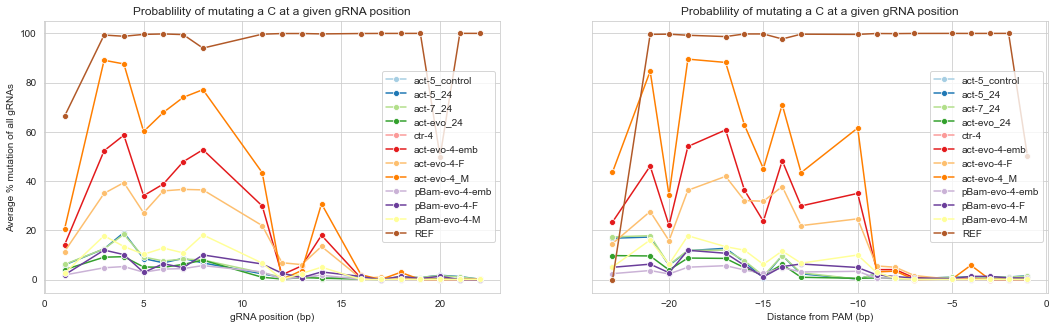

In [49]:
# CALCULATE AVERAGE MUTATION RATES OVER gRNAs
fig1, ax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(18,5))

samplei = 0
# for sample in Samples[0:-2]:
#AIDExperiments = [3, 4, 5, 11, 12, 13, 21, 22, 23]
#AIDExperiments = range(0,len(Samples)-2)
AIDExperiments = ExperimentSamples
for sample in AIDExperiments:
    AllMismatchesEachSample = MatrixMM_BG[samplei,:]
    EachMismatchesEachSample = DFMutations_BG[samplei]
    CTGAMismatchesEachSample = EachMismatchesEachSample['CT']+EachMismatchesEachSample['GA']
    MaxgRNAlength = max(gRNAsDF['End']-gRNAsDF['Start']+1)
    MgRNAsMMAlignedStart = np.zeros((len(gRNAsDF),MaxgRNAlength),float)
    MgRNAsMMAlignedPAM = np.zeros((len(gRNAsDF),MaxgRNAlength),float)

#     MgRNAsCTGA = np.zeros((len(gRNAsDF),MaxgRNAlength),float)
    for index, row in gRNAsDF.iterrows():  
        Start = row['Start']+len(PrimerFWD)
        End = row['End']+len(PrimerFWD)
        Orientation = row['Orientation']

        if Orientation == '+':
            isC = 'C'== np.array(list(GFPseqF[Start-1:End]))
            AvAllgRNAs = AllMismatchesEachSample[Start-1:End]*isC
            AvAllgRNAs[AvAllgRNAs==0] = None
#             AvCTGAgRNAs = CTGAMismatchesEachSample[row['Start']-1:row['End']]
        else:
            isC = 'G'== np.flip(np.array(list(GFPseqF[Start-1:End])))
            AvAllgRNAs = np.flip(AllMismatchesEachSample[Start-1:End])*isC
            AvAllgRNAs[AvAllgRNAs==0] = None
#             AvCTGAgRNAs = np.flip(CTGAMismatchesEachSample[row['Start']-1:row['End']])
        if len(AvAllgRNAs) < MaxgRNAlength:
            #aligning by PAM
            AvAllgRNAsEnd = [None]*(MaxgRNAlength-len(AvAllgRNAs)) + list(AvAllgRNAs)
#             AvCTGAgRNAs = [None]*(MaxgRNAlength-len(AvCTGAgRNAs)) + list(AvCTGAgRNAs)
            #aligning by start gRNA
            AvAllgRNAsStart = list(AvAllgRNAs) + [None]*(MaxgRNAlength-len(AvAllgRNAs))
#             AvCTGAgRNAs = list(AvCTGAgRNAs) + [None]*(MaxgRNAlength-len(AvCTGAgRNAs))
            #normalize to gRNA length??
        else:
            AvAllgRNAsStart = AvAllgRNAs
            AvAllgRNAsEnd = AvAllgRNAs
        MgRNAsMMAlignedStart[index,:] = AvAllgRNAsStart
        MgRNAsMMAlignedPAM[index,:] = AvAllgRNAsEnd
    sns.lineplot(x=range(1,MaxgRNAlength+1,1),y=np.nanmean(MgRNAsMMAlignedStart,0)*100,marker = 'o', ax = ax[0])
    sns.lineplot(x=range(-MaxgRNAlength,0,1),y=np.nanmean(MgRNAsMMAlignedPAM,0)*100, marker = 'o',ax = ax[1],palette='crest')
    samplei += 1
ax[0].set(title='Probablility of mutating a C at a given gRNA position',ylabel='Average % mutation of all gRNAs', xlabel='gRNA position (bp)')
ax[0].legend(labels=list(Descriptions[AIDExperiments]))
ax[1].set(title='Probablility of mutating a C at a given gRNA position',ylabel='Average % mutation of all gRNAs', xlabel='Distance from PAM (bp)')
sns.set_palette('Paired')
# ax[0].set(legend = Samples(ExperimentSamples))
ax[1].legend(labels=list(Descriptions[AIDExperiments]))
fig1.savefig(DirOut+"mutation_profile_avgRNAs"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")
#fig1.savefig('../'+"mutation_profile_avgRNAs"+str(len(FilesIn))+"-"+str(len(Files))+"files.pdf")

In [31]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open(Path+'plots-sup/data.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([Mismatch, DFMutations, Indels, N, Samples, Descriptions, ControlSamples, ExperimentSamples, NumberMutations, Neach, MgRNAsMMAlignedPAM], f)

# Getting back the objects:
# with open(Path+'plots-sup/data.pkl','rb') as f:  # Python 3: open(..., 'rb')
#     Mismatch, DFMutations, Indels, N, Samples, Descriptions, ControlSamples, ExperimentSamples, NumberMutations, Neach,MgRNAsMMAlignedPAM = pickle.load(f)

In [ ]:
# SubDF = DFall[DFall['Sample'] == '#11']
# Cbar_kws={'ticks':[],'label':'N      A      C      T      G      D','boundaries':[0,1,2,3,4,5,6]}
# hmA = sns.clustermap(SubDF.iloc[0:,len(PrimerFWD)+15:len(GFPseqF)-len(PrimerREV)-75],cmap="viridis",vmin=0, vmax=5,figsize=(16, 16),cbar_pos=(0.1, 0.5, 0.05, 0.12),col_cluster=False,row_cluster=True,cbar_kws=Cbar_kws)
# #hmM = sns.clustermap(SubDF.iloc[:,0:LibraryLength],col_cluster=False,row_cluster=False,figsize=(10, 10),vmin=0,vmax = Threshold, yticklabels=Descriptions, cbar_kws={'label': '% mismatch'})
# hmA.ax_cbar.set_position((0.075,0.6, .03, .2))
# hmA.fig.suptitle('% mismatched reads to GFP in each position after background subtraction from '+ str(round(len(FilesIn)/len(Files)*100)) + "% data ("+ str(len(FilesIn))+"/"+str(len(Files))+" files)")
# hmA.savefig(DirOut+"#11_heatmapAligned_SortedIndex_"+str(len(FilesIn))+"-"+str(len(Files))+"files.png")
# hmM.fig.clf()
# plt.close()